# Task 1 : Set up colab gpu runtime environment

Install all libraries being used in the project

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-1zx11l21
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-1zx11l21
  Resolved https://github.com/albumentations-team/albumentations to commit c70e664e060bfd7463c20674927aed217f72d437
  Preparing metadata (setup.py) ... done


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


Clone the dataset from the github mentioned

In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

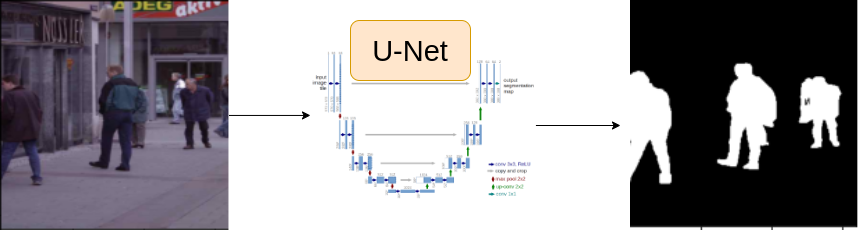

# Import libraries

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
csv_file = '/content/Human-Segmentation-Dataset-master/train.csv' ## filepath for CSV
data_dir = '/content/' ## directory where data is present

device ='cuda' # choose cude if running on gpu
epochs = 25 ## number of epochs
lr = 0.003 ## learning rate
img_size = 320 ## image size
batch_size = 16 ## batch_size

encoder = 'timm-efficientnet-b0'
weights ='imagenet'


In [6]:
df = pd.read_csv(csv_file)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[0]
image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255



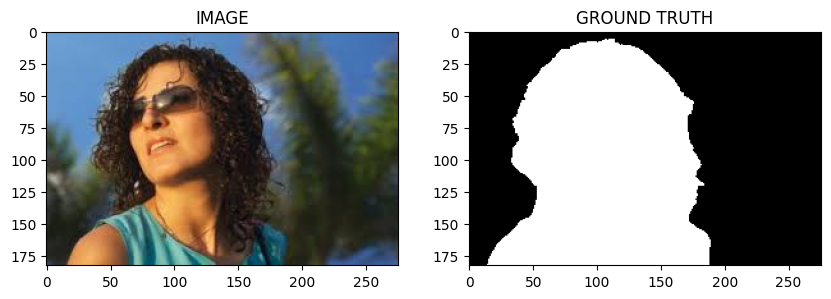

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df, valid_df = train_test_split(df, test_size =0.2, random_state = 42)

# Task 3 : Augmentation Functions

Note to self: unlike classification task, in segmentation task if we add data augmentation such as rotating the image, same rotation needs to be applied to label as well. Use of albumentation library.

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [11]:
def get_train_augs():
  return A.Compose([
      A.Resize(img_size, img_size),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)], is_check_shapes=False)

def get_valid_augs():
  return A.Compose([A.Resize(img_size, img_size)],is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations
  def __len__(self):
    return len(self.df)
  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #h,w
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    #pytorch requirement
    #(h,w,c) -> (c,h,w)
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    # pixel values between 0,1
    image = torch.Tensor(image)/255.0
    # pixel value 0 or 1
    mask = torch.round(torch.Tensor(mask)/255.0)

    return image, mask




In [14]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


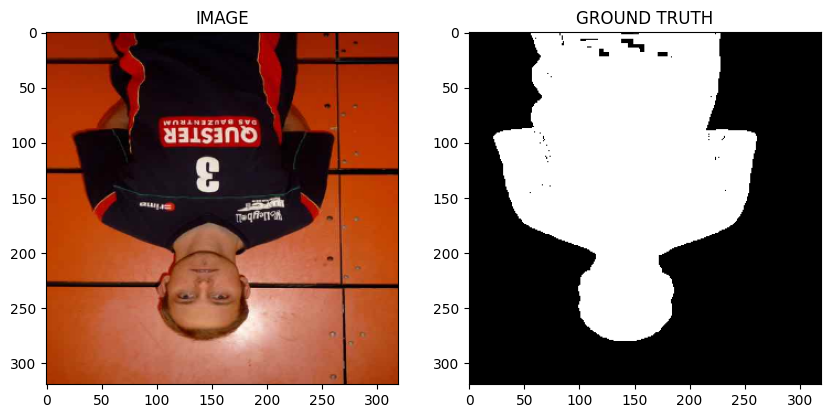

In [35]:
idx = 12
image, mask = trainset[idx]

helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [17]:
from torch.utils.data import DataLoader


In [18]:
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
validloader = DataLoader(validset, batch_size = batch_size)

In [19]:
print(f"total no. of batches in trainloader: {len(trainloader)}")
print(f"total no. of batches in validloader: {len(validloader)}")

total no. of batches in trainloader: 15
total no. of batches in validloader: 4


In [20]:
for image,mask in trainloader:
  break

print(f"One batch image shape: {image.shape}")
print(f"One batch mask shape: {mask.shape}")

One batch image shape: torch.Size([16, 3, 320, 320])
One batch mask shape: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [21]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import losses
from segmentation_models_pytorch.losses import DiceLoss

In [22]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(encoder_name = encoder,
                        encoder_weights= weights,
                        in_channels = 3,
                        classes = 1,
                        activation = None)
  def forward(self, images, masks=None):
    logits = self.arc(images)
    if masks!= None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1+loss2
    return logits

In [23]:
model = SegmentationModel()
model.to(device)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

In [24]:
def train_fn(dataloader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(dataloader):
    images = images.to(device)
    masks = masks.to(device)
    ## making sure gradients are zero
    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()

  return total_loss/len(dataloader)


In [25]:
def eval_fn(dataloader, model):
  model.eval()
  total_loss = 0.0
  with torch.no_grad():
    for images, masks in tqdm(dataloader):
      images = images.to(device)
      masks = masks.to(device)

      logits, loss = model(images, masks)


      total_loss+=loss.item()

    return total_loss/len(dataloader)

# Task 8 : Train Model

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr =lr)

In [27]:
best_valid_loss = np.Inf
for i in range(epochs):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED MODEL")
    best_valid_loss = valid_loss
  print(f"Epoch: {i+1} Train Loss: {train_loss} Valid Loss: {valid_loss}")

100%|██████████| 4/4 [00:01<00:00,  2.06it/s]


SAVED MODEL
Epoch: 1 Train Loss: 1.0042081634203592 Valid Loss: 4.175128698348999


100%|██████████| 4/4 [00:00<00:00,  5.21it/s]


SAVED MODEL
Epoch: 2 Train Loss: 0.4345747669537862 Valid Loss: 0.568332202732563


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


SAVED MODEL
Epoch: 3 Train Loss: 0.314961709578832 Valid Loss: 0.3516980819404125


100%|██████████| 4/4 [00:00<00:00,  5.29it/s]


SAVED MODEL
Epoch: 4 Train Loss: 0.37345663011074065 Valid Loss: 0.33844949305057526


100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


SAVED MODEL
Epoch: 5 Train Loss: 0.2619168072938919 Valid Loss: 0.25640980899333954


100%|██████████| 4/4 [00:00<00:00,  5.26it/s]


Epoch: 6 Train Loss: 0.2328760047753652 Valid Loss: 0.2639800161123276


100%|██████████| 4/4 [00:00<00:00,  5.24it/s]


SAVED MODEL
Epoch: 7 Train Loss: 0.20775583982467652 Valid Loss: 0.22689127177000046


100%|██████████| 4/4 [00:00<00:00,  5.21it/s]


SAVED MODEL
Epoch: 8 Train Loss: 0.1935469557841619 Valid Loss: 0.19017339497804642


100%|██████████| 4/4 [00:00<00:00,  5.23it/s]


Epoch: 9 Train Loss: 0.1716959958275159 Valid Loss: 0.1946207918226719


100%|██████████| 4/4 [00:00<00:00,  5.26it/s]


Epoch: 10 Train Loss: 0.15306318551301956 Valid Loss: 0.24646219611167908


100%|██████████| 4/4 [00:00<00:00,  5.24it/s]


Epoch: 11 Train Loss: 0.1523214613397916 Valid Loss: 0.2613738551735878


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


SAVED MODEL
Epoch: 12 Train Loss: 0.17187615633010864 Valid Loss: 0.17987094074487686


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


Epoch: 13 Train Loss: 0.150061696767807 Valid Loss: 0.20211654156446457


100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


Epoch: 14 Train Loss: 0.15036674241224926 Valid Loss: 0.23681828379631042


100%|██████████| 4/4 [00:00<00:00,  5.25it/s]


Epoch: 15 Train Loss: 0.15845769494771958 Valid Loss: 0.2853432148694992


100%|██████████| 4/4 [00:00<00:00,  4.53it/s]


Epoch: 16 Train Loss: 0.1469583973288536 Valid Loss: 0.2848719358444214


100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


Epoch: 17 Train Loss: 0.169752898812294 Valid Loss: 0.3016704209148884


100%|██████████| 4/4 [00:00<00:00,  5.17it/s]


Epoch: 18 Train Loss: 0.17949721614519756 Valid Loss: 0.21638190373778343


100%|██████████| 4/4 [00:00<00:00,  5.27it/s]


Epoch: 19 Train Loss: 0.13213177174329757 Valid Loss: 0.18872683867812157


100%|██████████| 4/4 [00:00<00:00,  5.08it/s]


Epoch: 20 Train Loss: 0.1479509060581525 Valid Loss: 0.20764098316431046


100%|██████████| 4/4 [00:00<00:00,  5.20it/s]


Epoch: 21 Train Loss: 0.1255455697576205 Valid Loss: 0.19824818521738052


100%|██████████| 4/4 [00:00<00:00,  5.25it/s]


Epoch: 22 Train Loss: 0.1306746482849121 Valid Loss: 0.20458514615893364


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


Epoch: 23 Train Loss: 0.12922954658667246 Valid Loss: 0.18188534677028656


100%|██████████| 4/4 [00:00<00:00,  5.24it/s]


Epoch: 24 Train Loss: 0.1331780547897021 Valid Loss: 0.28180234506726265


100%|██████████| 4/4 [00:01<00:00,  3.82it/s]

Epoch: 25 Train Loss: 0.11978277762730917 Valid Loss: 0.21602517366409302


# Task 9 : Inference

In [30]:
idx = 12

model.load_state_dict(torch.load('/content/best_model.pt'))

image,mask = validset[idx]

logits_mask = model(image.to(device).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask>0.5)*1.0

In [33]:
pred_mask =  pred_mask.detach().cpu().squeeze(0)

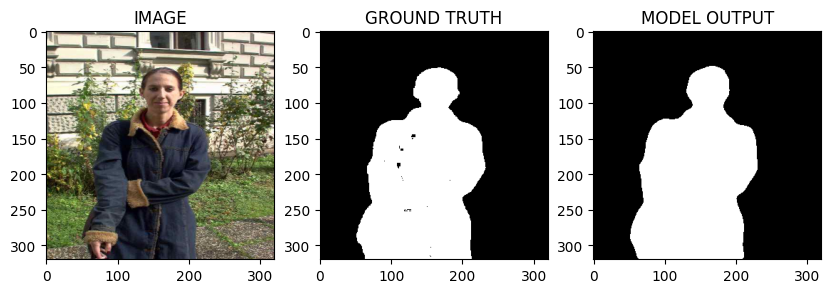

In [34]:
helper.show_image(image, mask,pred_mask)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya